In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocessing

In [2]:
image_size = (256,256)
batch_size = 32

potato_ds = tf.keras.utils.image_dataset_from_directory(
  "PlantVillage",
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True)

classes = potato_ds.class_names

Found 2152 files belonging to 3 classes.


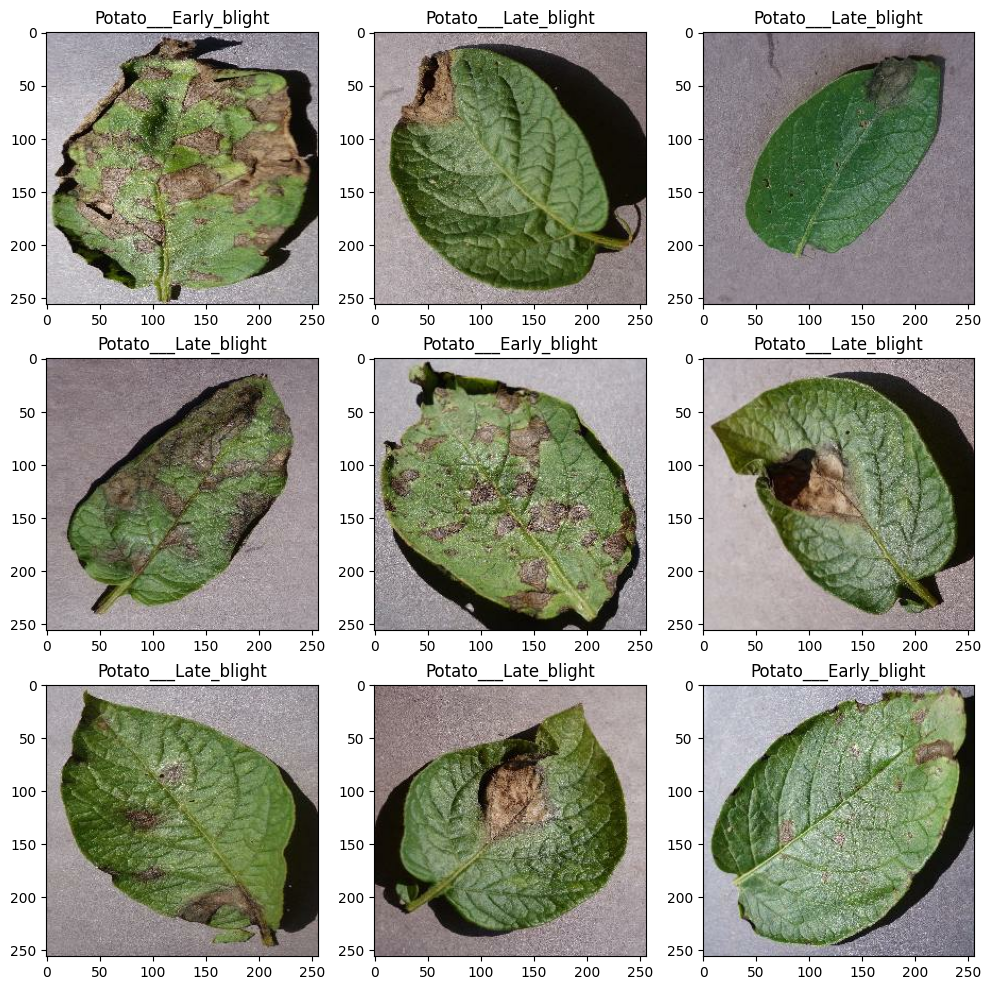

In [3]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in potato_ds.take(1):
    for i in range(9):
        axis = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(potato_ds.class_names[label_batch[i]])

%80 --> train  
%10 --> validation  
%10 --> test

In [4]:
train_size = int(len(potato_ds)*0.8)
validation_size = int(len(potato_ds)*0.1)

train_ds = potato_ds.take(train_size)
validation_ds = potato_ds.skip(train_size).take(validation_size)
test_ds = potato_ds.skip(train_size).skip(validation_size)


print(f"Train size in batch is {len(train_ds)}, validation size in batch is {len(validation_ds)}, test size in batch is {len(test_ds)}")

Train size in batch is 54, validation size in batch is 6, test size in batch is 8


In [5]:
train_ds = train_ds.shuffle(2000).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.shuffle(2000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(2000).prefetch(tf.data.AUTOTUNE)

In [6]:
model_preprocessing = models.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1/255.0),
])

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
	layers.RandomRotation(0.2)
])

In [8]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating the model

In [9]:
model = models.Sequential([
    model_preprocessing,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(256,256,3)),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
model.build(input_shape=(batch_size,256,256,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [10]:
model.compile(optimizer='adam',
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
history = model.fit(train_ds,validation_data=validation_ds,batch_size=batch_size, epochs=40)

Epoch 1/40
54/54 [==============================] - 23s 283ms/step - loss: 0.8914 - accuracy: 0.4763 - val_loss: 0.8633 - val_accuracy: 0.4323
Epoch 2/40
54/54 [==============================] - 15s 271ms/step - loss: 0.6539 - accuracy: 0.7002 - val_loss: 0.5416 - val_accuracy: 0.7552
Epoch 3/40
54/54 [==============================] - 16s 272ms/step - loss: 0.3837 - accuracy: 0.8356 - val_loss: 0.3043 - val_accuracy: 0.8802
Epoch 4/40
54/54 [==============================] - 15s 270ms/step - loss: 0.2985 - accuracy: 0.8819 - val_loss: 0.2302 - val_accuracy: 0.9115
Epoch 5/40
54/54 [==============================] - 15s 271ms/step - loss: 0.2737 - accuracy: 0.8935 - val_loss: 0.1622 - val_accuracy: 0.9375
Epoch 6/40
54/54 [==============================] - 15s 272ms/step - loss: 0.2343 - accuracy: 0.9051 - val_loss: 0.2428 - val_accuracy: 0.9115
Epoch 7/40
54/54 [==============================] - 15s 272ms/step - loss: 0.1880 - accuracy: 0.9265 - val_loss: 0.1368 - val_accuracy: 0.9531

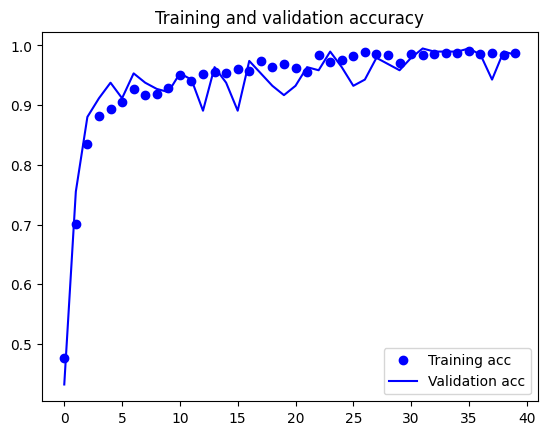

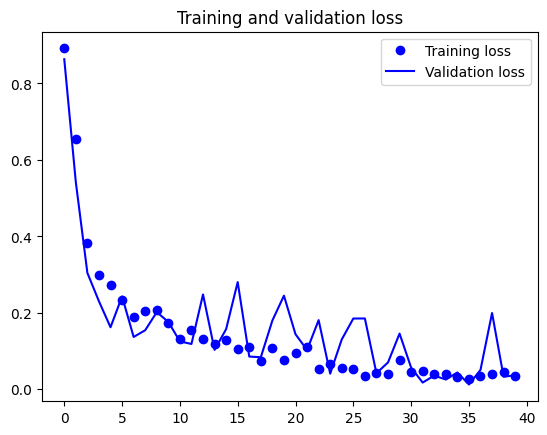

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 57ms/step - loss: 0.0277 - accuracy: 0.9871


[0.02765360288321972, 0.9870689511299133]

In [14]:
for image_batch, label_batch in test_ds.take(1):
    print(image_batch[1].shape, label_batch.shape)

(256, 256, 3) (32,)


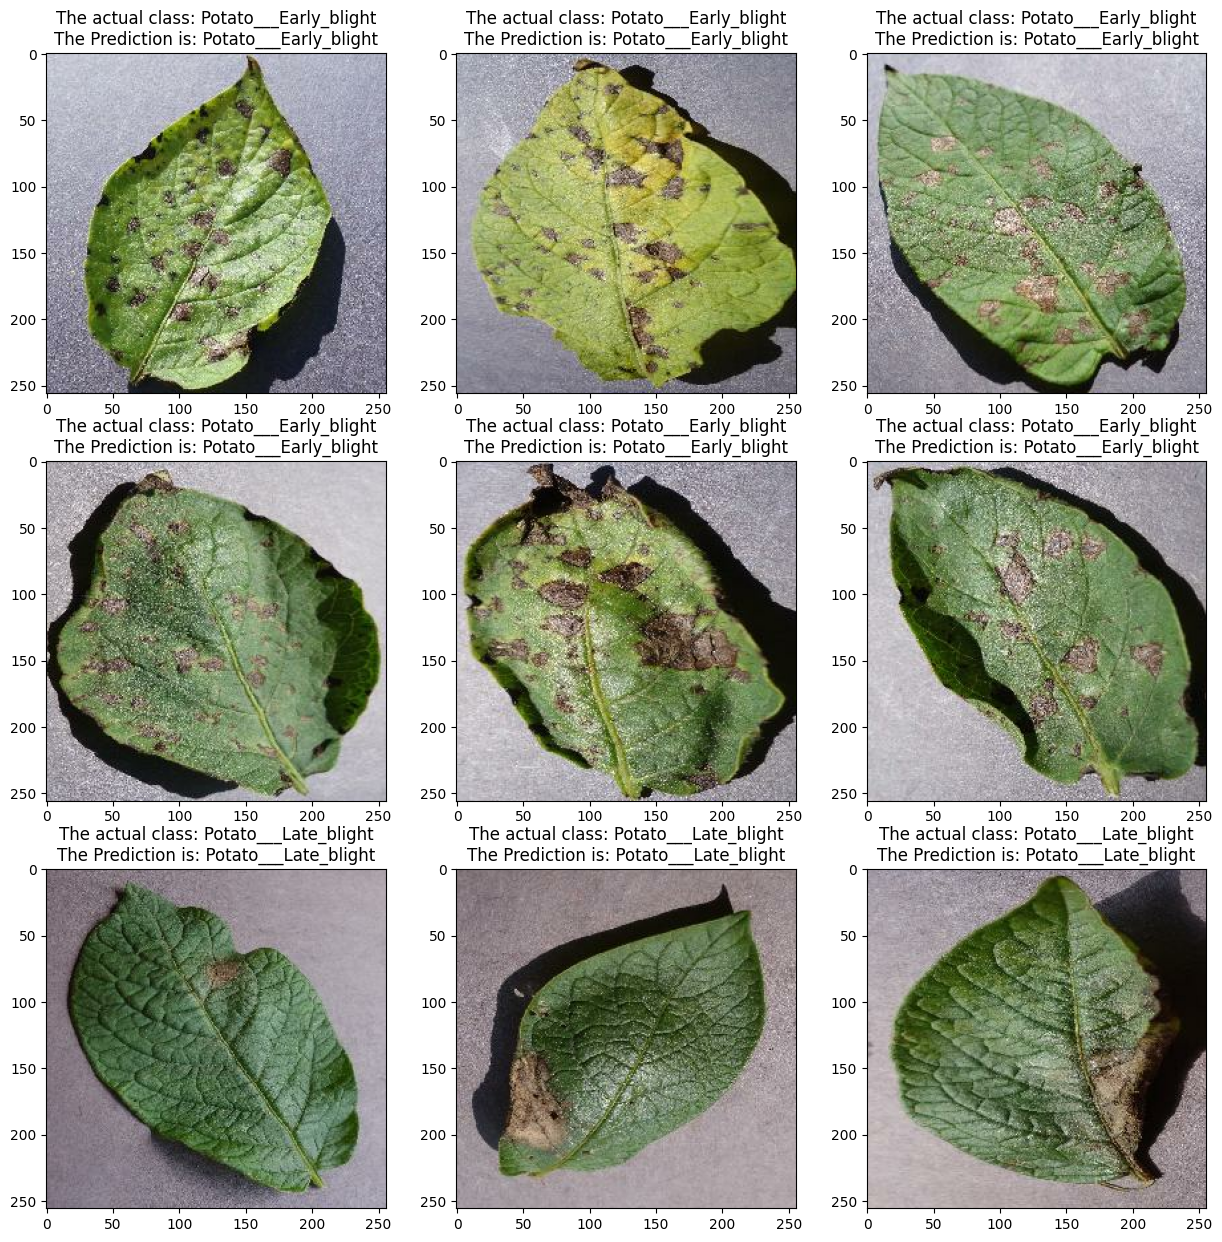

In [16]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        axis = plt.subplot(3,3, i+1)
        image = image_batch[i].numpy().astype('uint8')
        plt.imshow(image)
        label = label_batch[i].numpy()
        batch_predict = model.predict(image_batch)
        plt.title(f"The actual class: {classes[label]}\nThe Prediction is: {classes[np.argmax(batch_predict[i])]}")